In [2]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "jax"

# Note that Keras should only be imported after the backend
# has been configured. The backend cannot be changed once the
# package is imported.
import keras
import pydub
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from utils.waves import WaveGenerator
from utils.read_write import read, write

In [3]:
wg = WaveGenerator()

In [4]:
# Function to calculate frequency for a given musical note
def calculate_frequency(note, octave):
    A4_frequency = 440.0  # Frequency of A4 in Hz

    # Mapping of musical notes to their relative frequencies
    note_mapping = {'C': -9, 'C#': -8, 'Db': -8, 'D': -7, 'D#': -6, 'Eb': -6,
                    'E': -5, 'Fb': -5, 'E#': -4, 'F': -4, 'F#': -3, 'Gb': -3,
                    'G': -2, 'G#': -1, 'Ab': -1, 'A': 0, 'A#': 1, 'Bb': 1,
                    'B': 2, 'Cb': 2, 'B#': 3}

    # Calculate the frequency using the formula: f = A4 * 2^(n/12), where n is the note difference
    frequency = A4_frequency * (2 ** ((note_mapping[note] + (octave - 4) * 12) / 12.0))

    return frequency

# Generate the dictionary for musical notes from C1 to C8
musical_notes = {}
for octave in range(1, 9):
    for note in ['C', 'C#', 'Db', 'D', 'D#', 'Eb', 'E', 'Fb', 'E#', 'F', 'F#', 'Gb', 'G', 'G#', 'Ab', 'A', 'A#', 'Bb', 'B', 'Cb', 'B#']:
        note_name = f"{note}{octave}"
        frequency = calculate_frequency(note, octave)
        musical_notes[note_name] = frequency

musical_notes_inv = {val: key for key, val in musical_notes.items()}
musical_notes_inv

{32.70319566257483: 'C1',
 34.64782887210901: 'Db1',
 36.70809598967594: 'D1',
 38.890872965260115: 'Eb1',
 41.20344461410875: 'Fb1',
 43.653528929125486: 'F1',
 46.2493028389543: 'Gb1',
 48.999429497718666: 'G1',
 51.91308719749314: 'Ab1',
 55.0: 'A1',
 58.27047018976124: 'Bb1',
 61.7354126570155: 'Cb1',
 65.40639132514966: 'C2',
 69.29565774421802: 'Db2',
 73.41619197935188: 'D2',
 77.78174593052023: 'Eb2',
 82.4068892282175: 'Fb2',
 87.30705785825097: 'F2',
 92.4986056779086: 'Gb2',
 97.99885899543733: 'G2',
 103.82617439498628: 'Ab2',
 110.0: 'A2',
 116.54094037952248: 'Bb2',
 123.47082531403103: 'Cb2',
 130.8127826502993: 'C3',
 138.59131548843604: 'Db3',
 146.8323839587038: 'D3',
 155.56349186104046: 'Eb3',
 164.81377845643496: 'Fb3',
 174.61411571650194: 'F3',
 184.9972113558172: 'Gb3',
 195.99771799087463: 'G3',
 207.65234878997256: 'Ab3',
 220.0: 'A3',
 233.08188075904496: 'Bb3',
 246.94165062806206: 'Cb3',
 261.6255653005986: 'C4',
 277.1826309768721: 'Db4',
 293.664767917407

In [5]:
freqs = [73.42, 98.00, 196.00, 98.00]
secs = [2, 0.5, 0.25, 2]
write("sick_beat.mp3", 48000, wg.gen_sequence('sine', freqs, secs), normalized=True)

In [6]:
from tensorflow.keras.models import load_model

model_eval = load_model('../models/note_detect.h5', compile=False)

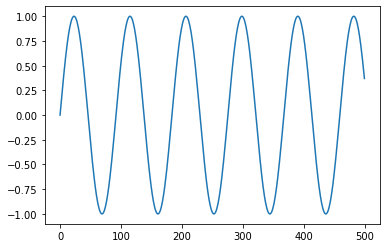

In [7]:
X_test = wg.gen_sequence('sine', freqs=[musical_notes['C5'], musical_notes['A8']], secs=[0.2, 0.2])
plt.plot(X_test[:500])
plt.show()

In [8]:
X_test = read('twinkle.mp3')[1][:, 0]

In [9]:
def get_closest_note(freq):
    rounded_freq = min(musical_notes.values(), key = lambda x: abs(x - freq))
    return musical_notes_inv.get(rounded_freq)

In [10]:
chunk_size = 750
n_chunks = len(X_test) // chunk_size

result = []
for chunk in np.split(X_test[:chunk_size*n_chunks], n_chunks):
    result.append(model_eval.predict(np.expand_dims(chunk, 0))[0])

In [11]:
notes = [get_closest_note(freq) for freq in result]

# Mapping of note names to y-values based on pitch
note_pitch_mapping = {'D2': 1, 'D#2': 2, 'Eb2': 2, 'E2': 3, 'Fb2': 3, 'E#2': 4,
                      'F2': 4, 'F#2': 5, 'Gb2': 5, 'G2': 6, 'G#2': 7, 'Ab2': 7,
                      'A2': 8, 'A#2': 9, 'Bb2': 9, 'B2': 10, 'Cb2': 10, 'B#2': 11,
                      'C3': 11, 'C#3': 12, 'Db3': 12, 'D3': 13, 'D#3': 14, 'Eb3': 14,
                      'E3': 15, 'Fb3': 15, 'E#3': 16, 'F3': 16, 'F#3': 17, 'Gb3': 17,
                      'G3': 18, 'G#3': 19, 'Ab3': 19, 'A3': 20, 'A#3': 21, 'Bb3': 21,
                      'B3': 22, 'Cb3': 22, 'B#3': 23, 'C4': 23, 'C#4': 24, 'Db4': 24,
                      'D4': 25, 'D#4': 26, 'Eb4': 26, 'E4': 27, 'Fb4': 27, 'E#4': 28,
                      'F4': 28, 'F#4': 29, 'Gb4': 29, 'G4': 30, 'G#4': 31, 'Ab4': 31,
                      'A4': 32, 'A#4': 33, 'Bb4': 33, 'B4': 34, 'Cb4': 34, 'B#4': 35,
                      'C5': 35, 'C#5': 36, 'Db5': 36, 'D5': 37, 'D#5': 38, 'Eb5': 38,
                      'E5': 39, 'Fb5': 39, 'E#5': 40, 'F5': 40, 'F#5': 41, 'Gb5': 41,
                      'G5': 42, 'G#5': 43, 'Ab5': 43, 'A5': 44, 'A#5': 45, 'Bb5': 45,
                      'B5': 46, 'Cb5': 46, 'B#5': 47, 'C6': 47, 'C#6': 48, 'Db6': 48,
                      'D6': 49, 'D#6': 50, 'Eb6': 50, 'E6': 51, 'Fb6': 51, 'E#6': 52,
                      'F6': 52, 'F#6': 53, 'Gb6': 53, 'G6': 54, 'G#6': 55, 'Ab6': 55,
                      'A6': 56, 'A#6': 57, 'Bb6': 57, 'B6': 58, 'Cb6': 58, 'B#6': 59,
                      'C7': 59, 'C#7': 60, 'Db7': 60, 'D7': 61, 'D#7': 62, 'Eb7': 62,
                      'E7': 63, 'Fb7': 63, 'E#7': 64, 'F7': 64, 'F#7': 65, 'Gb7': 65,
                      'G7': 66}

# Generate y-axis values based on pitch
y_values = [note_pitch_mapping[note] for note in notes]

# Create a scatter plot or bar plot
plt.figure(figsize=(8, 6))
plt.scatter(range(len(notes)), y_values, marker='^', color='red', label='Music Notes')
plt.title('Music Notes Visualization')
plt.xlabel('Note Index')
plt.ylabel('Note Pitch')
plt.yticks(list(note_pitch_mapping.values()), list(note_pitch_mapping.keys()))  # Show note names on y-axis

# Annotate each point with the corresponding note
for x, y, note in zip(range(len(notes)), y_values, notes):
    plt.annotate(note, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

plt.legend()
plt.figure(figsize=(50, 10))  # Adjust the width to make the plot longer
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

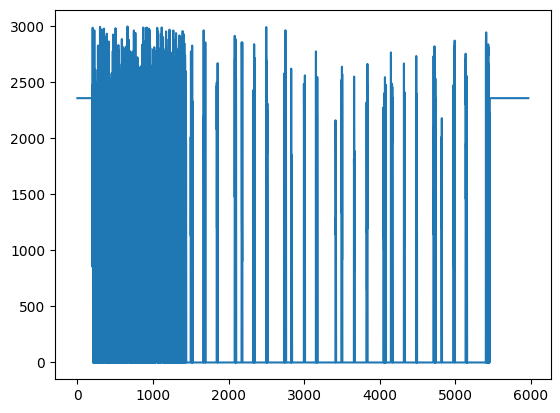

In [ ]:
res = np.array(result)
res[res >= 3000] = 0
plt.plot(res)

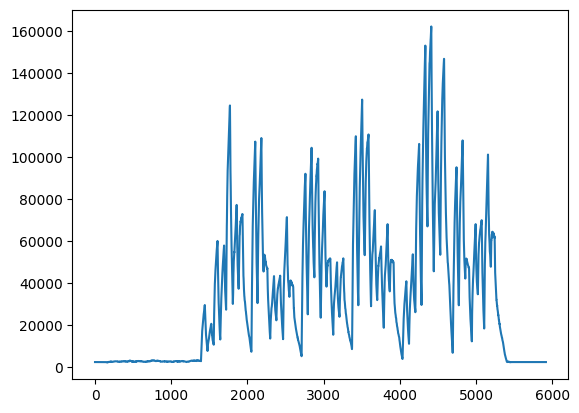

In [ ]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.plot(moving_average(result, n=50))